## Now We Will Try to convet **Savaal Pipeline** To code.

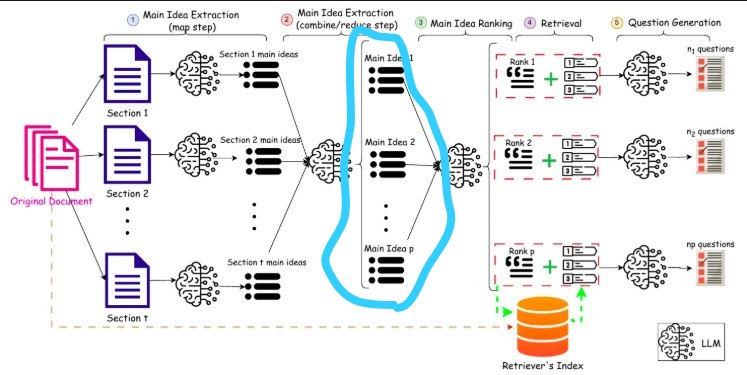

##  IMPORTS & SETUP

In [5]:
!pip install -qU langchain langchain_core langchain-cohere langchain-community faiss-cpu pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 93.5 MB/s eta 0:00:00


In [6]:
from langchain_cohere import ChatCohere, CohereEmbeddings
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from pydantic import BaseModel, Field
from typing import List
from dataclasses import dataclass
import os
import asyncio
import json
from datetime import datetime
from google.colab import userdata



✓ Imports complete and LLM initialized


#### Get Cohere API KEY From Here [HERE](https://dashboard.cohere.com/api-keys)

In [37]:
# Initialize LLMs
os.environ["COHERE_API_KEY"]=userdata.get("COHERE_API_KEY")

generation_model_id="command-a-03-2025"
embedding_model_id="embed-english-v3.0"


llm = ChatCohere(model=generation_model_id)
embedding = CohereEmbeddings(model=embedding_model_id)

## DATA MODELS & HELPER CLASSES

In [14]:
class MainIdea(BaseModel):
    name: str = Field(..., description="Main idea name")
    summary: str = Field(..., description="Detailed full-sentence summary explaining the concept, its relevance, any examples or applications, its connections to other ideas, and its role in understanding the material.")

class MainIdeas(BaseModel):
    MainIdeas: List[MainIdea]

class Ranking(BaseModel):
    ranking: List[int] = Field(..., description='Rank corresponding to each idea')

class StagePrompt(BaseModel):
    system: str
    human: str

def reranked(ideas, ranking):
    """Reorder ideas based on ranking"""
    assert len(ideas) == len(ranking), "ideas and ranking lists are not of the same length"
    ranked_ideas = [None] * len(ranking)
    for idea, rank in zip(ideas, ranking):
        ranked_ideas[rank-1] = idea
    return ranked_ideas

##  STAGE 1 - DOCUMENT SPLITTING

In [18]:
# Read the document
with open('/content/01 - u1_Past Simple.txt', 'r') as file:
    doc = file.read()

# Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = splitter.split_text(doc)

print(f"Document split into {len(chunks)} chunks")


Document split into 9 chunks


## STAGE 2 - MAIN IDEA EXTRACTION

In [19]:
extrct_prompt = StagePrompt(
    system="Instructions:\n"
    "You are an expert educator specializing in creating detailed concept maps from academic texts. Given the following excerpt from a longer document, extract the main ideas, detailed concepts, and supporting details that are critical to understanding the material.\n"
    "Focus on identifying:\n\n"
    "- Key concepts or terms introduced in the text.\n"
    "- Definitions or explanations of these concepts.\n"
    "- Relationships between concepts.\n"
    "- Any examples or applications mentioned.\n"
    "Use clear, bullet-point summaries, organized by topic. Never add any commentary\n"
    "",
    human="Here is the excerpt:\n"
    "Context:\n"
    "{context}"
)

extrct_prompt_tmplt = ChatPromptTemplate.from_messages([
    ("system", extrct_prompt.system),
    ("human", extrct_prompt.human)])

extrct_chain = extrct_prompt_tmplt | llm

# Process chunks in parallel
async def process_chunk(chunk):
    ideas = await extrct_chain.ainvoke(input={'context': chunk})
    return ideas.content

async def process_all_chunks(chunks):
    tasks = [process_chunk(chunk) for chunk in chunks]
    results = await asyncio.gather(*tasks)
    return "".join(results)

# Run extraction
collected_ideas = await process_all_chunks(chunks)

print("Extraction complete from all chunks")
print(f"Total extracted ideas length: {len(collected_ideas)} characters\n")

Extraction complete from all chunks
Total extracted ideas length: 15296 characters



## STAGE 3 - COMBINE IDEAS

In [20]:
combine_prompt = StagePrompt(
    system="Instructions:\n"
    "You are combining multiple concept maps into a single, comprehensive summary while retaining all key ideas and details. Below are several lists of main ideas and concepts extracted from a larger document.\n"
    "Your task is to:\n\n"
    "1. Merge these lists into a single structured list, removing redundancies while keeping all unique and detailed information.\n"
    "2. Ensure all main ideas, relationships, and examples are preserved and clearly organized. Never add any commentary",

    human="Here are the concept maps to combine:\n"
    "Context:\n"
    "{context}"
)

combine_prmpt_tmplt = ChatPromptTemplate.from_messages([
    ("system", combine_prompt.system),
    ("human", combine_prompt.human)
])

combine_chain = combine_prmpt_tmplt | llm

combined = combine_chain.invoke(input={'context': collected_ideas})

print("Ideas combined successfully")

Ideas combined successfully


## STAGE 4 - REDUCE TO MAIN IDEAS

In [21]:
reduce_parser = PydanticOutputParser(pydantic_object=MainIdeas)

reduce_prompt = StagePrompt(
    system="Instructions:\n"
    "You are reducing sets of detailed concept maps into a concise yet comprehensive list of important concepts, generated by extracting concepts from a document and potentially combining subsets of them that are relevant to each other.\n"
    "The goal is to create a structured resource that fully captures the essence of the material for testing and teaching purposes.\n"
    "Your task is to:\n\n"
    "- Identify the most critical concepts from the detailed concept map.\n"
    "- Provide a full-sentence summary for each concept that explains its significance, its relationship to other concepts, and any relevant examples or applications.\n"
    "- Ensure that the summaries are clear, self-contained, and detailed enough to aid in understanding without requiring additional context.\n"
    "- If necessary, combine related concepts into a single summary. Some of the concept maps have broader headings that can be used to guide this process.\n"
    "Answer in the following format:\n"
    ""+reduce_parser.get_format_instructions().replace('{', '{{').replace('}', '}}'),

    human="Here is the detailed concept map:\n"
    "Context:\n"
    "{context}\n"
)

reduce_prmpt_tmplt = ChatPromptTemplate.from_messages([
    ("system", reduce_prompt.system),
    ("human", reduce_prompt.human)
])

reduce_chain = reduce_prmpt_tmplt | llm | reduce_parser

reduced = reduce_chain.invoke(input={'context': combined.content})

print(f"Reduced to {len(reduced.MainIdeas)} main ideas\n")

Reduced to 10 main ideas



In [22]:
for i, idea in enumerate(reduced.MainIdeas, 1):
    print(f"{i}. {idea.name}")
    print(f"   {idea.summary[:100]}...\n")

1. Past Simple Tense
   The Past Simple tense describes completed actions in the past, formed with the subject followed by t...

2. Past Tense Categories
   Past tenses are categorized into Past Obvious (with explicit indicators), Past Obvious Implicit (wit...

3. Past Habits vs. Past Actions
   Past habits refer to repeated actions in the past, expressed using 'used to' or the simple past tens...

4. Present Perfect for Recent Past
   The Present Perfect tense connects recent past actions to the present, often used to describe the re...

5. Time Expressions with Past Simple
   Specific time expressions like 'yesterday,' 'last + duration,' 'duration + ago,' 'in + year,' and 't...

6. Past Continuous Tense
   The Past Continuous tense describes actions that were ongoing at a specific past time, formed with t...

7. Conditional and Hypothetical Structures
   Conditional and hypothetical structures express wishes, suppositions, and imaginary comparisons. 'Wi...

8. Other Uses of Past Simp

## STAGE 5 - RANKING IDEAS

In [23]:
rank_parser = PydanticOutputParser(pydantic_object=Ranking)

rank_prompt = StagePrompt(
    system="Instructions:\n"
    "Given the following groups of main ideas extracted from a text, rank them in order of importance, with the most important main idea receiving a rank of 1 and lower ranks for less important ideas.\n"
    "Focus on the most important aspects of the text and the main ideas that are critical to understanding the material.\n"
    "While sometimes important, background information or less critical ideas should be ranked lower.\n"
    "When ranking:\n\n"
    "- Assign a unique number to each main idea, starting from 1.\n"
    "- Ensure that the most important main idea is ranked first.\n"
    "- Rank the main ideas based on their relevance and significance.\n"
    "- If necessary, combine related concepts into a single summary.\n\n"
    "Example:\n"
    "Input: [Main Idea 1, Main Idea 2, Main Idea 3]\n"
    "Output: [2, 1, 3]\n\n"
    "Respond in the following format:\n"
    ""+rank_parser.get_format_instructions().replace('{', '{{').replace('}', '}}'),

    human="Main Ideas:\n"
    "{context}",
)

rank_prmpt_tmplt = ChatPromptTemplate.from_messages([
    ("system", rank_prompt.system),
    ("human", rank_prompt.human)
])

rank_chain = rank_prmpt_tmplt | llm | rank_parser

ranked = rank_chain.invoke(input={'context': reduced})

ranked_ideas = reranked(ideas=reduced.MainIdeas, ranking=ranked.ranking)

print("Ideas ranked by It's importance\n")

Ideas ranked by It's importance



In [24]:
for i, idea in enumerate(ranked_ideas, 1):
    print(f"Rank {i}: {idea.name}")
    print(f"   {idea.summary[:100]}...\n")

Rank 1: Past Simple Tense
   The Past Simple tense describes completed actions in the past, formed with the subject followed by t...

Rank 2: Past Tense Categories
   Past tenses are categorized into Past Obvious (with explicit indicators), Past Obvious Implicit (wit...

Rank 3: Past Habits vs. Past Actions
   Past habits refer to repeated actions in the past, expressed using 'used to' or the simple past tens...

Rank 4: Present Perfect for Recent Past
   The Present Perfect tense connects recent past actions to the present, often used to describe the re...

Rank 5: Time Expressions with Past Simple
   Specific time expressions like 'yesterday,' 'last + duration,' 'duration + ago,' 'in + year,' and 't...

Rank 6: Past Continuous Tense
   The Past Continuous tense describes actions that were ongoing at a specific past time, formed with t...

Rank 7: Conditional and Hypothetical Structures
   Conditional and hypothetical structures express wishes, suppositions, and imaginary comparisons.

## STAGE 6 - BUILD RETRIEVAL INDEX

In [25]:
ideas_text_list = [f"{idea.name}\n{idea.summary}" for idea in ranked_ideas]

vectorstore = FAISS.from_texts(ideas_text_list, embedding)
retriever = vectorstore.as_retriever()


## STAGE 7 - QUESTION GENERATION

In [27]:
question_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """You are an expert educator. Generate exam questions based on the user's requested type.

     Guidelines:
     - ALWAYS generate the exact question type requested.
     - Use the concept text to craft meaningful assessment questions.
     - No answers unless requested.

     Supported Types:
     - "mcq" (Multiple Choice)
     - "true/false"
     - "critical thinking"
     - "fill in the blanks"
     - "short answer"
     - "matching"

     When generating:
     - For MCQ → give 4 options a/b/c/d
     - For T/F → statements only
     - For Critical Thinking → deep reasoning questions
     - For Fill in the blanks → remove key words
     - For Matching → create two shuffled lists

     """),

    ("human",
     "Question Type: {qtype}\n\nConcept:\n{context}\n\nGenerate {number_questions} questions of the specified type.")
])

question_chain = question_prompt | llm

In [33]:
questions_per_idea = []
user_question_type = ["mcq", "true/false"]  # Change this: "true/false", "critical thinking"
number_questions = 3


for i, idea in enumerate(ideas_text_list, 1):

    concept_text = idea

    q_output = question_chain.invoke({
        "context": concept_text,
        "qtype": user_question_type,
        "number_questions":number_questions
    })

    print(f"\n=== Questions for Idea Rank {i} ===\n")
    print(q_output.content)

    questions_per_idea.append(q_output.content)


=== Questions for Idea Rank 1 ===

**Multiple Choice Questions (MCQ):**

1. Which of the following sentences is in the Past Simple tense?
a) Dalia has travelled to Aswan.
b) Dalia will travel to Aswan.
c) Dalia travelled to Aswan a week ago.
d) Dalia is travelling to Aswan.

2. What is the correct Past Simple form of the verb 'write'?
a) writes
b) writing
c) wrote
d) written

3. Which sentence correctly uses the Past Simple tense to describe a past habit?
a) Yahya Haqqi writes many interesting short stories every year.
b) Yahya Haqqi has written many interesting short stories.
c) Yahya Haqqi wrote many interesting short stories.
d) Yahya Haqqi will write many interesting short stories.

**True/False Questions:**

4. The Past Simple tense is used to describe actions that are still ongoing. (True/False)

5. The sentence 'Dalia travelled to Aswan a week ago' is an example of the Past Simple tense. (True/False)

6. The Past Simple tense links past actions to the present, just like the Pre

## STAGE 8 - ANSWER GENERATION

In [38]:
answer_prompt = ChatPromptTemplate.from_messages([
    ("system",
     """You are an expert educator providing answer keys for exam questions.

     Guidelines:
     - Provide ONLY the correct answers in a clear, concise format.
     - For MCQ: State the letter (a/b/c/d) and the correct answer.
     - For T/F: State True or False.
     - For Critical Thinking: Provide sample answer/key points.
     - For Fill in the blanks: Provide the missing words.
     - For Short Answer: Provide concise answer.
     - For Matching: Provide the correct pairs.
     - Be brief and direct.
     """),

    ("human",
     "Question Type: {qtype}\n\nConcept:\n{context}\n\nQuestions:\n{questions}\n\nProvide the answer key.")
])

answer_chain = answer_prompt | llm

print("\n" + "=" * 60)
print("ANSWER KEYS")
print("=" * 60)

answer_keys = []

for i, (idea, questions) in enumerate(zip(ideas_text_list, questions_per_idea), 1):

    a_output = answer_chain.invoke({
        "context": idea,
        "qtype": user_question_type,
        "questions": questions
    })

    print(f"\n=== Answer Key for Idea Rank {i} ===\n")
    print(a_output.content)

    answer_keys.append(a_output.content)


ANSWER KEYS

=== Answer Key for Idea Rank 1 ===

**Answer Key:**

**Multiple Choice Questions (MCQ):**

1. c) Dalia travelled to Aswan a week ago.
2. c) wrote
3. c) Yahya Haqqi wrote many interesting short stories.

**True/False Questions:**

4. False
5. True
6. False

=== Answer Key for Idea Rank 2 ===

**MCQ Answers:**

1. d) The sun set behind the mountains.  
2. a) I woke up, had breakfast, and then went to work.  
3. b) Children played outside after school in the old days.  

**True/False Answers:**

1. True.  
2. False.  
3. False.

=== Answer Key for Idea Rank 3 ===

**MCQ Answers:**

1. b) I used to play soccer every weekend when I was younger.
2. b) My family and I went hiking in the mountains last month.
3. a) I went to the gym three times a week last year.

**True/False Answers:**

1. False
2. True
3. False

=== Answer Key for Idea Rank 4 ===

**MCQ Answers:**

1. b) I have been to the store, so I have the groceries we need.
2. c) To describe the result of an action connect